# Imports

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, ConfusionMatrixDisplay, confusion_matrix
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

---

# Problem :
Provide actionable recommendations to a ride sharing company to help them reduce their attrition rates by predicting whether a driver will be leaving the company or not based on their attributes like demographics, Tenure information, performance of the driver.


# Insights : 
- 68% of drivers leave the company
- Last Working data is negatively correlated with Quarterly Rating (-0.34), Total Business value (-0.29) and Grade (-0.22)
- LastWorkingDate has strong correlation with quarterly_rating_increased (-0.41) and TBV_std (-0.32)
- Test Data ROC AUC Score : 
    - Random Forest Classifier : 0.74
    - XGBoost Classifier : 0.77
- Most important features:
    - If the quarterly rating increases or not
    - Total Business value generated by driver
    - Quarterly Rating of driver
    

# Recommendations : 
- The ride sharing company needs to reach out to drivers who have generated low Business value in the last quarter and understand what they are doing wrong, solve their tech issues (if any) and suggest some strategies which have worked for other drivers and help them  boost their revenue generation in the upcoming quarter. 
- Increasing Quarterly Rating has a huge impact on drivers decision to stay in the company. So the ride sharing company should update their policy to be more liberal in increasing rating of drivers and try to decouple it from the total business value generated by them.

In [2]:
df_og = pd.read_csv('driver.csv')

In [3]:
df_og.shape

(19104, 14)

In [4]:
df_og.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,01/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,02/01/19,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,03/01/19,1,28.0,0.0,C23,2,57387,24/12/18,03/11/19,1,1,0,2
3,3,11/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1
4,4,12/01/20,2,31.0,0.0,C7,2,67016,11/06/20,NaN,2,2,0,1


In [5]:
df_og = df_og.drop(columns=['Unnamed: 0'])

---

## Aggregating data

In [6]:
df = df_og.groupby('Driver_ID').agg({'Age':'mean',
                                    'Gender':'first',
                                    'City':'first',
                                    'Education_Level':'first',
                                    'Income':'mean',
                                    'LastWorkingDate':'last',
                                    'Joining Designation':'first',
                                    'Grade':'mean',
                                    'Total Business Value':'sum',
                                    'Quarterly Rating':'mean'}).reset_index()

In [7]:
df.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,1,28.0,0.0,C23,2,57387.0,03/11/19,1,1.0,1715580,2.0
1,2,31.0,0.0,C7,2,67016.0,None,2,2.0,0,1.0
2,4,43.0,0.0,C13,2,65603.0,27/04/20,2,2.0,350000,1.0
3,5,29.0,0.0,C9,0,46368.0,03/07/19,1,1.0,120360,1.0
4,6,31.0,1.0,C11,1,78728.0,None,3,3.0,1265000,1.6


In [8]:
# Converting LastWorkingDate to a binary class 
df.loc[df['LastWorkingDate'].notna(),'LastWorkingDate'] = 1 # Left the company
df.loc[df['LastWorkingDate'].isna(),'LastWorkingDate'] = 0 # Still in company

In [9]:
round(df['LastWorkingDate'].value_counts(1) * 100)

1    68.0
0    32.0
Name: LastWorkingDate, dtype: float64

- 68% drivers have left the company

# EDA

In [10]:
df.shape

(2381, 11)

In [11]:
#converting dtypes
df = df.astype({'Gender':'str',
              'LastWorkingDate':'int',
              'Education_Level':'str',
              'Joining Designation':'str'})

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Driver_ID             2381 non-null   int64  
 1   Age                   2381 non-null   float64
 2   Gender                2381 non-null   object 
 3   City                  2381 non-null   object 
 4   Education_Level       2381 non-null   object 
 5   Income                2381 non-null   float64
 6   LastWorkingDate       2381 non-null   int32  
 7   Joining Designation   2381 non-null   object 
 8   Grade                 2381 non-null   float64
 9   Total Business Value  2381 non-null   int64  
 10  Quarterly Rating      2381 non-null   float64
dtypes: float64(4), int32(1), int64(2), object(4)
memory usage: 195.4+ KB


- No null values observed

In [13]:
df.describe()

,Driver_ID,Age,Income,LastWorkingDate,Grade,Total Business Value,Quarterly Rating
count,2381.000000,2381.000000,2381.000000,2381.000000,2381.000000,2.381000e+03,2381.000000
mean,1397.559009,33.369298,59232.460484,0.678706,2.081713,4.586742e+06,1.566304
std,806.161628,5.890567,28298.214012,0.467071,0.932257,9.127115e+06,0.719652
min,1.000000,21.000000,10747.000000,0.000000,1.000000,-1.385530e+06,1.000000
25%,695.000000,29.000000,39104.000000,0.000000,1.000000,0.000000e+00,1.000000
50%,1400.000000,33.000000,55285.000000,1.000000,2.000000,8.176800e+05,1.000000
75%,2100.000000,37.000000,75835.000000,1.000000,3.000000,4.173650e+06,2.000000
max,2788.000000,58.000000,188418.000000,1.000000,5.000000,9.533106e+07,4.000000


In [14]:
df.describe(include='O')

,Gender,City,Education_Level,Joining Designation
count,2381,2381,2381,2381
unique,2,29,3,5
top,0.0,C20,2,1
freq,1404,152,802,1026


## Univariate

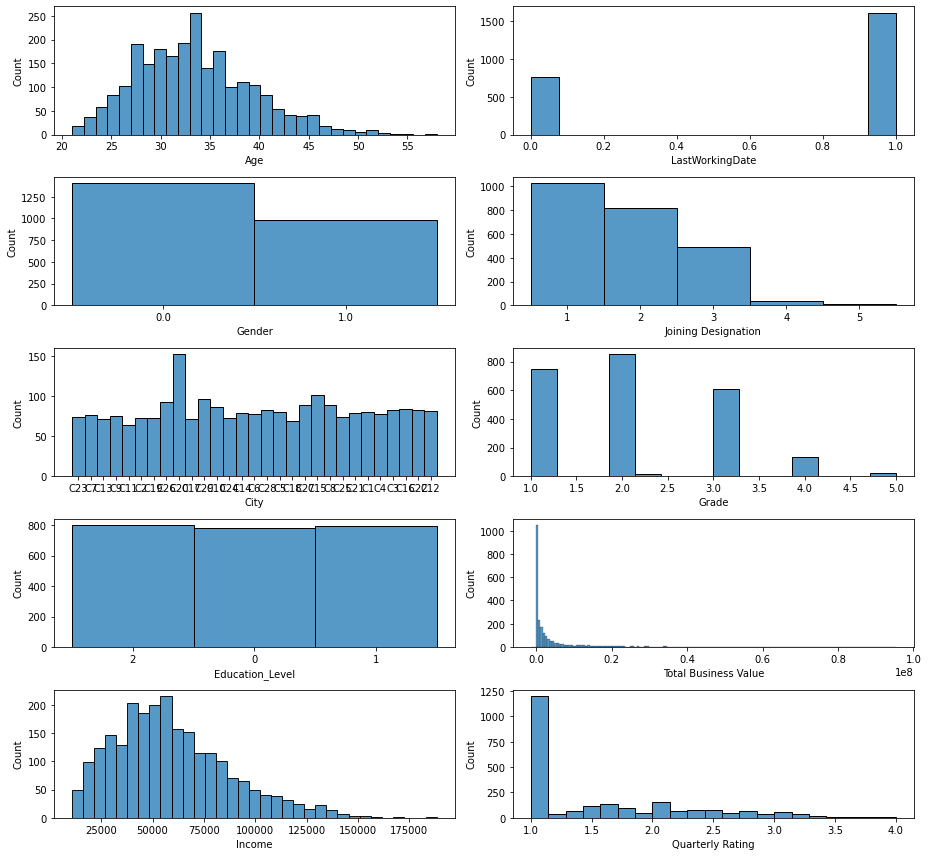

In [15]:
fig,ax = plt.subplots(5,2,figsize=(13,12))
for e,c in enumerate(df.columns[1:]):
    sns.histplot(df[c], ax=ax[e%5][0 if e<5 else 1])
plt.tight_layout()

- Age and Income are normally distributed
- Majority gender is male
- Total business value seems to have some outliers

## Bivariate

<AxesSubplot:>

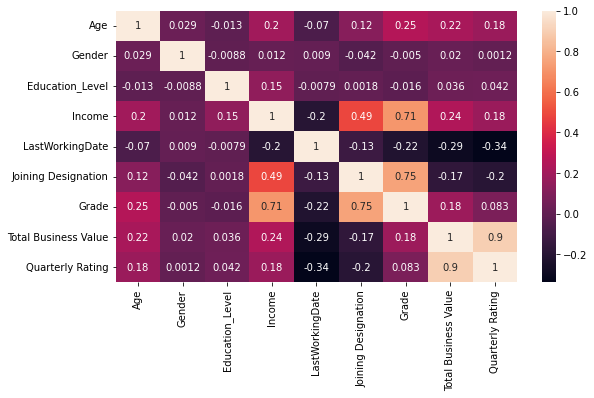

In [16]:
plt.rcParams['figure.figsize'] = 9,5
sns.heatmap(df.drop(columns=['City','Driver_ID']).apply(pd.to_numeric).corr(method='spearman'), annot=True)

- Total Business Value and Quarterly rating have very high correlation ~ 0.9
- Grade is highly correlated with Income (0.71) and Joining Designation (0.75)
- Last Working data is negatively correlated with Quarterly Rating (-0.34), Total Business value (-0.29) and Grade (-0.22)

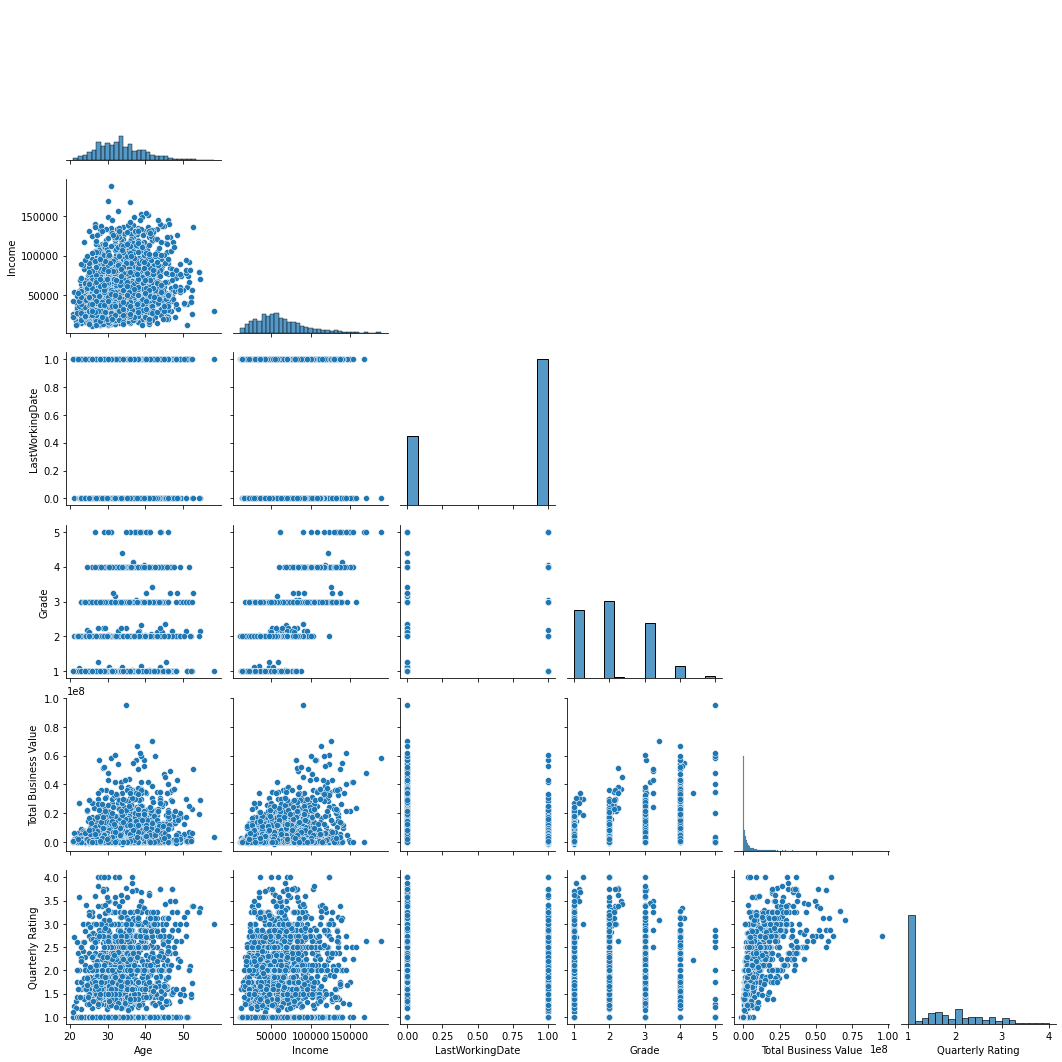

In [17]:
sns.pairplot(df.drop(columns=['Driver_ID']), corner=True)

# Data Preprocessing

## Feature Engineering

In [18]:
# Income increased Flag

income = df_og.groupby('Driver_ID').agg({'Income': ['first','last']}).reset_index()

income['income_increased'] = (income[(   'Income', 'last')]  > income[(   'Income', 'first')]).astype(int)

income = income[['Driver_ID','income_increased']]

income.columns = ['Driver_ID','income_increased']

df = df.merge(income)

In [19]:
# Quarterly Rating increased Flag

quarterly_rating = df_og.groupby('Driver_ID').agg({'Quarterly Rating': ['first','last']}).reset_index()

quarterly_rating['quarterly_rating_increased'] = (quarterly_rating[(   'Quarterly Rating', 'last')]  > quarterly_rating[(   'Quarterly Rating', 'first')]).astype(int)

quarterly_rating = quarterly_rating[['Driver_ID','quarterly_rating_increased']]

quarterly_rating.columns = ['Driver_ID','quarterly_rating_increased']

df = df.merge(quarterly_rating)

In [20]:
# Standard Deviation of Total Business Value

TBV_std = df_og.groupby('Driver_ID').agg({'Total Business Value': 'std'}).reset_index()

TBV_std.columns = ['Driver_ID','TBV_std']

df = df.merge(TBV_std)

In [21]:
df.head()

,Driver_ID,Age,Gender,City,Education_Level,Income,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating,income_increased,quarterly_rating_increased,TBV_std
0,1,28.0,0.0,C23,2,57387.0,1,1,1.0,1715580,2.0,0,0,1.601755e+06
1,2,31.0,0.0,C7,2,67016.0,0,2,2.0,0,1.0,0,0,0.000000e+00
2,4,43.0,0.0,C13,2,65603.0,1,2,2.0,350000,1.0,0,0,1.565248e+05
3,5,29.0,0.0,C9,0,46368.0,1,1,1.0,120360,1.0,0,0,6.948988e+04
4,6,31.0,1.0,C11,1,78728.0,0,3,3.0,1265000,1.6,0,1,5.657252e+05


<AxesSubplot:>

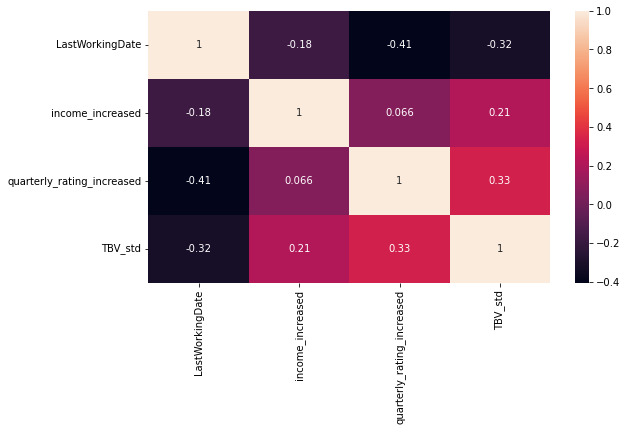

In [22]:
sns.heatmap(df[['LastWorkingDate','income_increased','quarterly_rating_increased','TBV_std']].corr(method='spearman'),annot=True)

- LastWorkingDate has strong correlation with quarterly_rating_increased (-0.41) and TBV_std (-0.32)

## Train Test Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['LastWorkingDate']), df['LastWorkingDate'], test_size=0.20, random_state=42)

In [24]:
y_train.mean(), y_test.mean()

(0.6769957983193278, 0.6855345911949685)

In [25]:
y_train.shape, y_test.shape

((1904,), (477,))

----

## Encoding

In [26]:
te = TargetEncoder()

In [27]:
X_train = te.fit_transform(X_train, y_train)

## Imputation

In [28]:
X_train.isna().sum()

Driver_ID                       0
Age                             0
Gender                          0
City                            0
Education_Level                 0
Income                          0
Joining Designation             0
Grade                           0
Total Business Value            0
Quarterly Rating                0
income_increased                0
quarterly_rating_increased      0
TBV_std                       145
dtype: int64

In [29]:
knn = KNNImputer()

In [30]:
X_train.loc[:,:] = knn.fit_transform(X_train)

## Class Imbalance treatment

In [31]:
smote = SMOTE(sampling_strategy=1, random_state=42)

In [32]:
y_train.mean(), y_train.shape

(0.6769957983193278, (1904,))

In [33]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [34]:
y_train.mean(), y_train.shape

(0.5, (2578,))

## Standardization

In [35]:
ss = StandardScaler()
X_train.loc[:,:] = ss.fit_transform(X_train)

---

## Creating Test Set

In [36]:
X_test = te.transform(X_test, y_test)
X_test.loc[:,:] = knn.transform(X_test)
X_test.loc[:,:] = ss.transform(X_test)

# Model Building

In [37]:
RFC_param_grid = {'n_estimators':[100,500,800],
                'max_depth':[4,6,8],
                'max_samples':[0.4,0.8],
                 'ccp_alpha':[0.07,0.14,0.2]}

rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [58]:
XGB_param_grid = {'n_estimators':[50,100,200],
                'max_depth':[2,4,6],
                'subsample':[0.4,0.8],
                 'reg_lambda':[500,1000,2000]}

xgb = XGBClassifier(random_state=42, n_jobs=-1, learning_rate=0.01)

In [59]:
for estimator,param_grid in zip([rfc, xgb], [RFC_param_grid, XGB_param_grid]):
    print(estimator.__class__)
    gscv = GridSearchCV(estimator=estimator,param_grid=param_grid,scoring='roc_auc',refit=False, cv=5,verbose=0)
    gscv.fit(X_train, y_train)
    print(gscv.best_params_, gscv.best_score_)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
{'ccp_alpha': 0.07, 'max_depth': 6, 'max_samples': 0.4, 'n_estimators': 100} 0.7869653605073214
<class 'xgboost.sklearn.XGBClassifier'>
{'max_depth': 6, 'n_estimators': 200, 'reg_lambda': 500, 'subsample': 0.8} 0.8391200698102315


## Random Forest 

In [38]:
# Using best params from GridsearchCV
rfc = RandomForestClassifier(max_depth=6, max_samples=0.4, n_estimators=100,
                             random_state=42, n_jobs=-1, ccp_alpha=0.07)

In [39]:
cross_val_score(rfc, X_train, y_train, scoring='roc_auc', cv=5).mean()

0.7869653605073214

In [40]:
rfc.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.07, max_depth=6, max_samples=0.4, n_jobs=-1,
                       random_state=42)

In [41]:
# Test data ROC AUC Score
roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1])

0.7410601427115189

Text(0, 0.5, 'TPR')

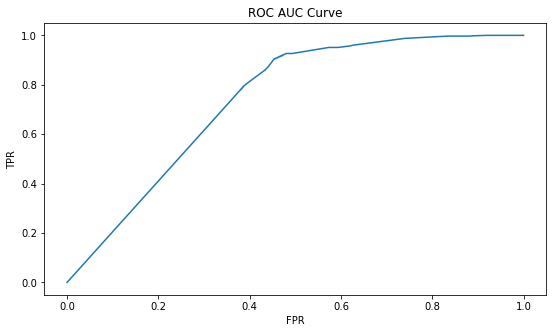

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, rfc.predict_proba(X_test)[:,1])

g = sns.lineplot(fpr, tpr)
g.set_title('ROC AUC Curve')
g.set_xlabel('FPR')
g.set_ylabel('TPR')

In [43]:
print(classification_report(y_test, rfc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.73      0.54      0.62       150
           1       0.81      0.91      0.86       327

    accuracy                           0.79       477
   macro avg       0.77      0.72      0.74       477
weighted avg       0.79      0.79      0.78       477



- f1 score ~ 0.86

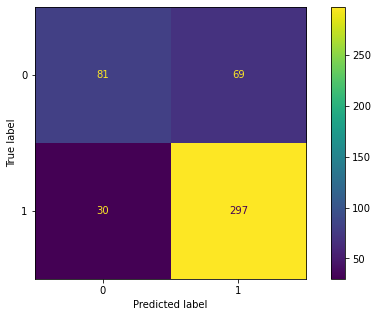

In [46]:
ConfusionMatrixDisplay(confusion_matrix(y_test, rfc.predict(X_test))).plot()

- FN : 30 drivers
- FP : 69 drivers

### Top  features

In [47]:
feat_imp = pd.DataFrame({'Features':X_train.columns, 'Imp':rfc.feature_importances_}).sort_values('Imp',ascending=False).head()
feat_imp

,Features,Imp
11,quarterly_rating_increased,0.442009
8,Total Business Value,0.357991
9,Quarterly Rating,0.200000
0,Driver_ID,0.000000
1,Age,0.000000


- only 3 features are being used in the model

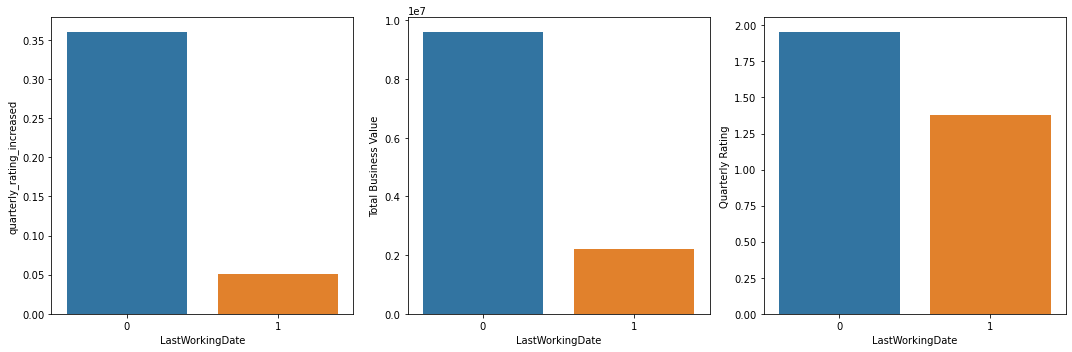

In [48]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for e, c in enumerate(['quarterly_rating_increased','Total Business Value','Quarterly Rating']):
    tmp = df.groupby('LastWorkingDate')[c].mean().reset_index()
    sns.barplot(tmp['LastWorkingDate'], tmp[c], ax=ax[e])
plt.tight_layout()

- Drivers who leave have :
    - No increase in quarterly ratings
    - Less Total Business value
    - Low quarterly rating

## XGB

In [49]:
# Using best params from gridsearchCV
xgb = XGBClassifier(max_depth=6, n_estimators=200, subsample=0.8,
                    random_state=42, n_jobs=-1, reg_lambda=500, learning_rate=0.01)

In [50]:
cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=5).mean()

0.8391200698102315

In [51]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [52]:
# Test data ROC AUC Score
roc_auc_score(y_test, xgb.predict_proba(X_test)[:,1])

0.7714882772680939

Text(0, 0.5, 'TPR')

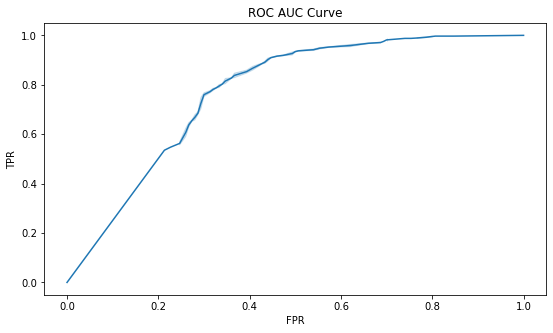

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

g = sns.lineplot(fpr, tpr)
g.set_title('ROC AUC Curve')
g.set_xlabel('FPR')
g.set_ylabel('TPR')

In [54]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.64      0.63      0.64       150
           1       0.83      0.83      0.83       327

    accuracy                           0.77       477
   macro avg       0.73      0.73      0.73       477
weighted avg       0.77      0.77      0.77       477



- f1 score ~ 0.83

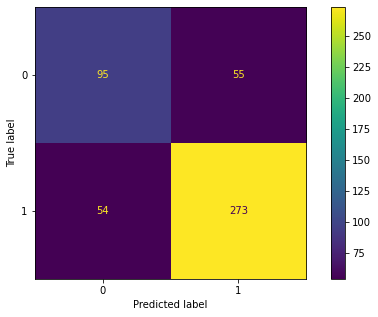

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_test, xgb.predict(X_test))).plot()

- FN : 54 drivers
- FP : 55 drivers

### Top features

In [56]:
feat_imp = pd.DataFrame({'Features':X_train.columns, 'Imp':xgb.feature_importances_}).sort_values('Imp',ascending=False).head()
feat_imp

,Features,Imp
11,quarterly_rating_increased,0.611847
6,Joining Designation,0.197731
8,Total Business Value,0.117140
9,Quarterly Rating,0.027253
7,Grade,0.017221


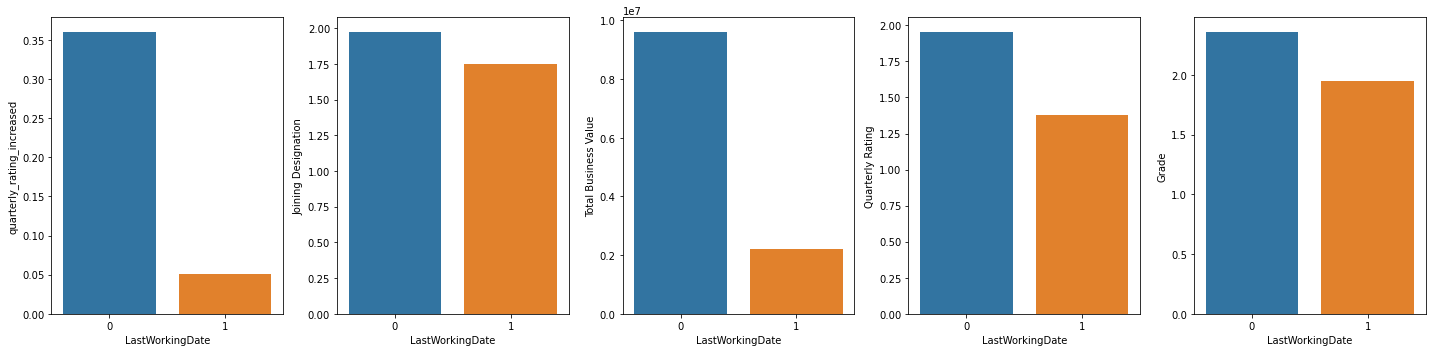

In [57]:
fig,ax = plt.subplots(1,5,figsize=(20,5))
for e, c in enumerate(['quarterly_rating_increased','Joining Designation','Total Business Value',
                      'Quarterly Rating','Grade']):
    df[c] = df[c].astype(float)
    tmp = df.groupby('LastWorkingDate')[c].mean().reset_index()
    sns.barplot(tmp['LastWorkingDate'], tmp[c], ax=ax[e])
plt.tight_layout()

- Drivers who leave have :
    - No increase in quarterly ratings
    - Less Total Business value
    - Low quarterly rating
    - Low Grade
    - Low Joining Designation

----